# Install necessary libraries

In [16]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid, train_test_split



# Loading and preprocessing the dataset

In [2]:
!git clone "https://github.com/cincin-2399/Stock-Price-Prediction-Using-ML-and-DL-techniques.git"

Cloning into 'Stock-Price-Prediction-Using-ML-and-DL-techniques'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 106 (delta 21), reused 7 (delta 2), pack-reused 0
Receiving objects: 100% (106/106), 2.49 MiB | 7.25 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [7]:
path='/kaggle/working/Stock-Price-Prediction-Using-ML-and-DL-techniques/Data/processed/GAS_dropna.csv'
df = pd.read_csv(path)

df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d")
df = df.sort_values('Date') 
df = df.reset_index(drop=True)
df = df.set_index('Date') 
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-21,30833.333984,34250.000000,30833.333984,34166.667969,32736.435547,3002495.0
2012-05-22,35833.332031,35833.332031,35416.667969,35833.332031,34333.332031,5801459.0
2012-05-23,35750.000000,35833.332031,34083.332031,34083.332031,32656.587891,1266935.0
2012-05-24,32500.000000,33333.332031,32416.666016,32416.666016,31059.689453,1211255.0
2012-05-25,32416.666016,33166.667969,30916.666016,32500.000000,31139.535156,1112711.0
2012-05-28,32666.666016,32666.666016,31250.000000,31333.333984,30021.707031,548879.0
2012-05-29,30250.000000,30833.333984,30083.333984,30583.333984,29303.101563,501959.0
2012-05-30,30833.333984,31583.333984,30583.333984,31500.000000,30181.394531,204335.0
2012-05-31,31000.000000,31500.000000,30583.333984,31000.000000,29702.326172,322835.0


In [9]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaler = MinMaxScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-05-21,0.065094,0.098392,0.069767,0.103676,0.103676,0.278772
2012-05-22,0.121698,0.116367,0.123062,0.122526,0.122526,0.538934
2012-05-23,0.120755,0.116367,0.107558,0.102733,0.102733,0.117453
2012-05-24,0.083962,0.087985,0.088178,0.083883,0.083883,0.112278
2012-05-25,0.083019,0.086093,0.070736,0.084826,0.084826,0.103118
2012-05-28,0.085849,0.080416,0.074612,0.071631,0.071631,0.050710
2012-05-29,0.058491,0.059603,0.061047,0.063148,0.063148,0.046349
2012-05-30,0.065094,0.068117,0.066860,0.073516,0.073516,0.018685
2012-05-31,0.066981,0.067171,0.066860,0.067861,0.067861,0.029700


# Spliting the dataset into X and y

# Setting up the model

In [29]:
def performXGBoost(X_train, y_train, X_test, y_test, parameters, return_model=False):
    #reshape the input data from 3D to 2D
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    
    print(f"Training XGBoost model with parameters: {parameters}")
    
    XGBoost_model = XGBRegressor(n_estimators=parameters['n_estimators'], 
                                 max_depth=parameters['max_depth'], 
                                 learning_rate=parameters['learning_rate'],
                                 objective='reg:squarederror', 
                                 random_state=42) 
    
    XGBoost_model.fit(X_train_reshaped, y_train, verbose=False)
    
    y_pred_train = XGBoost_model.predict(X_train_reshaped)
    y_pred_test = XGBoost_model.predict(X_test_reshaped)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"Training RMSE: {rmse_train:.4f}")
    print(f"Testing RMSE: {rmse_test:.4f}")
    print(f"Training MAPE: {mape_train:.4f}")
    print(f"Testing MAPE: {mape_test:.4f}")
    print(f"Training R2 score: {r2_train:.4f}")
    print(f"Testing R2 score: {r2_test:.4f}")
    print("---")
    
    if return_model==False:
        return [rmse_train, rmse_test, mape_train, mape_test, r2_train, r2_test]
    else:
        return XGBoost_model, [rmse_train, rmse_test, mape_train, mape_test, r2_train, r2_test]

## Since the dataset is time series type, so in order to find out the best parameters for the model, we choose Cross Validation for Time series as our approach.

In [13]:
def CV_timeseries_hypertuning(X, y, number_folds):
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    param_list = list(ParameterGrid(param_grid))
    
    results_valid = []
    results_test = []
    
    k = int(np.floor(X.shape[0] / number_folds))
    
    for i in range(3, number_folds + 1):
        print(f"Fold {i}/{number_folds}")
        
        split = (i - 1) / i
        index = int(np.floor(X.shape[0] * split))
        
        X_train_validFolds = X[:index]
        y_train_validFolds = y[:index]
        
        index_valid = int((i - 2) * index / (i - 1))
        
        X_trainFolds = X_train_validFolds[:index_valid]
        y_trainFolds = y_train_validFolds[:index_valid]
        X_validFolds = X_train_validFolds[index_valid:]
        y_validFolds = y_train_validFolds[index_valid:]
        
        X_testFolds = X[index:]
        y_testFolds = y[index:]
        
        for params in param_list:
            metrics_valid = performXGBoost(X_trainFolds, y_trainFolds, X_validFolds, y_validFolds, params)
            results_valid.append({
                'parameters': params,
                'rmse_train': metrics_valid[0],
                'rmse_valid': metrics_valid[1],
                'mape_train': metrics_valid[2],
                'mape_valid': metrics_valid[3],
                'r2_train': metrics_valid[4],
                'r2_valid': metrics_valid[5]
            })
        
        sorted_results_valid = sorted(results_valid, key=lambda x: x['rmse_valid'])
        best_parameters = sorted_results_valid[0]['parameters']
        
        print(f"Best parameters for fold {i}: {best_parameters}")
        
        metrics_test = performXGBoost(X_train_validFolds, y_train_validFolds, X_testFolds, y_testFolds, best_parameters)
        results_test.append({
            'parameters': best_parameters,
            'rmse_train': metrics_test[0],
            'rmse_test': metrics_test[1],
            'mape_train': metrics_test[2],
            'mape_test': metrics_test[3],
            'r2_train': metrics_test[4],
            'r2_test': metrics_test[5]
        })
    
    avg_results = {
        'rmse_train': np.mean([result['rmse_train'] for result in results_test]),
        'rmse_test': np.mean([result['rmse_test'] for result in results_test]),
        'mape_train': np.mean([result['mape_train'] for result in results_test]),
        'mape_test': np.mean([result['mape_test'] for result in results_test]),
        'r2_train': np.mean([result['r2_train'] for result in results_test]),
        'r2_test': np.mean([result['r2_test'] for result in results_test])
    }
    
    print("Average results:")
    print(f"Training RMSE: {avg_results['rmse_train']:.4f}")
    print(f"Testing RMSE: {avg_results['rmse_test']:.4f}")
    print(f"Training MAPE: {avg_results['mape_train']:.4f}")
    print(f"Testing MAPE: {avg_results['mape_test']:.4f}")
    print(f"Training R2 score: {avg_results['r2_train']:.4f}")
    print(f"Testing R2 score: {avg_results['r2_test']:.4f}")
    
    best_params_overall = sorted_results_valid[0]['parameters']
    print(f"Overall best parameters: {best_params_overall}")
    
    return avg_results, best_params_overall


In [14]:
avg_results, best_params_overall=CV_timeseries_hypertuning(X,y,5)

Fold 3/5
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Training RMSE: 0.0826
Testing RMSE: 0.1095
Training MAPE: 776916194026.6443
Testing MAPE: 0.1420
Training R2 score: 0.8545
Testing R2 score: 0.6918
---
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Training RMSE: 0.0102
Testing RMSE: 0.0260
Training MAPE: 122924471084.6043
Testing MAPE: 0.0314
Training R2 score: 0.9978
Testing R2 score: 0.9827
---
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
Training RMSE: 0.0084
Testing RMSE: 0.0259
Training MAPE: 76506006830.6680
Testing MAPE: 0.0316
Training R2 score: 0.9985
Testing R2 score: 0.9828
---
Training XGBoost model with parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Training RMSE: 0.0818
Testing RMSE: 0.1094
Training MAPE: 715934002520.4963
Testing MAPE: 0.1391
Training R2 score: 0.8571
Testing 

# Training the model and use it for prediction

In [30]:
X_train,X_test,y_train,y_test=convert_dataset(df,time_step=30,split=True,test_size=0.3)
val_size = len(X_test) // 2  

X_val = X_test[:val_size]
y_val = y_test[:val_size]

X_test = X_test[val_size:]
y_test = y_test[val_size:]

XGBoost_model, score = performXGBoost(X_train,y_train,X_val,y_val,best_params_overall,return_model=True)

Training XGBoost model with parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Training RMSE: 0.0145
Testing RMSE: 0.0256
Training MAPE: 88023769992.1154
Testing MAPE: 0.0279
Training R2 score: 0.9958
Testing R2 score: 0.9600
---


In [34]:
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
y_pred = XGBoost_model.predict(X_test_reshaped)

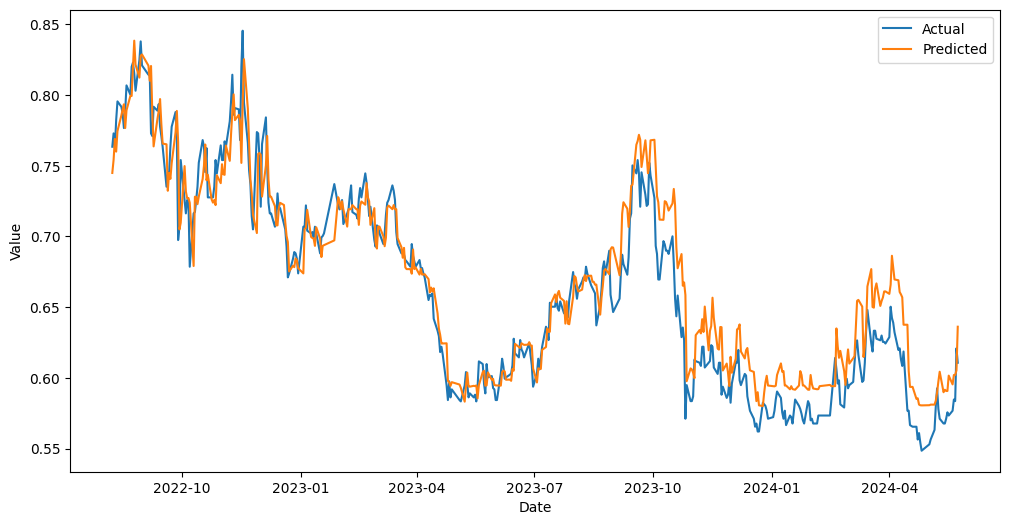

In [36]:
test_dates = df.index[-len(X_test):]

pred_df = pd.DataFrame({'Date': test_dates, 'Predicted': y_pred})
pred_df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(X_test):], y_test, label='Actual')
plt.plot(pred_df.index, pred_df['Predicted'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [37]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAPE:", mape)
print("R2 score:", r2)

RMSE: 0.022223829827542056
MAPE: 0.026404237243491363
R2 score: 0.902480951662019
